# Financial Signal Processing Coursework

## 1 Regression Methods

### 1.1 Processing stock price data in Python

#### 1.1.1 Importing Stock Price Data

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
px = pd.read_csv("priceData.csv", index_col="date")
px = px.dropna() # Clean nan values 

In [24]:
#dates = px["date"]
px = px["SPX Index"]

#### 1.1.1  Natural-log transform of the price

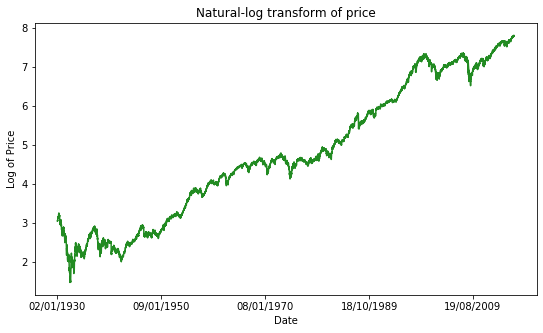

In [25]:
logpx = np.log(px)
plt.figure(figsize=(9,5))
logpx.plot(color="forestgreen")
plt.xlabel("Date")
plt.ylabel("Log of Price")
plt.title("Natural-log transform of price")
plt.show()

#### 1.1.2 Sliding window based first and second order statistics. (COME BACK TO THIS)

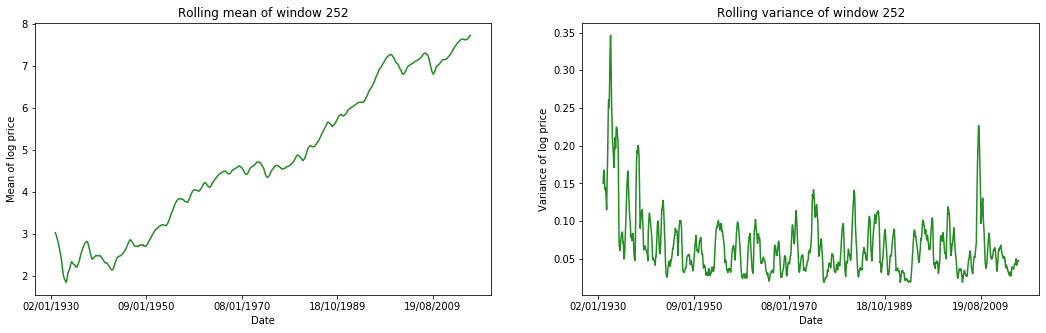

In [26]:
# sliding mean
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
logpx.rolling(252).mean().plot(color="forestgreen")
plt.xlabel("Date")
plt.title("Rolling mean of window 252")
plt.ylabel("Mean of log price")
# sliding standard deviation
plt.subplot(1,2,2)
logpx.rolling(252).std().plot(color="forestgreen")
plt.xlabel("Date")
plt.title("Rolling variance of window 252")
plt.ylabel("Variance of log price")
plt.show()

As can be oberved above the log prices are neither first order or second order stationary with both the mean and variance changing as time progresses. T

#### 1.1.3 Simple and log return time-series from the price data

In [27]:
# log return 
logret = logpx.diff()

#simple return
simpret = px.pct_change()

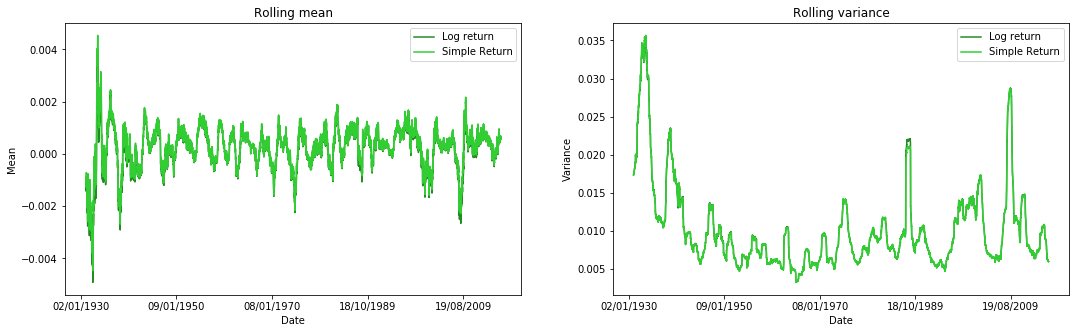

In [28]:
# sliding mean
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
logret.rolling(252).mean().plot(color="forestgreen")
simpret.rolling(252).mean().plot(color="limegreen")
plt.xlabel("Date")
plt.title("Rolling mean")
plt.ylabel("Mean")
plt.legend(["Log return","Simple Return"])
plt.subplot(1,2,2)
logret.rolling(252).std().plot(color="forestgreen")
simpret.rolling(252).std().plot(color="limegreen")
plt.xlabel("Date")
plt.title("Rolling variance")
plt.ylabel("Variance")
plt.legend(["Log return","Simple Return"])
plt.show()


From the above plots it can be argued that the price returns (both simple and log) are first order stationary through out the time series and for sections of the time series they also appear to be second order stationary as well. 

#### 1.1.4 Suitability of log returns over simple returns for signal processing purposes.

The logarithmic return for a market price at time t is defined as $r[t]$ where:
$$r[t]=\log\frac{p[t]}{p[t-1]}$$

Logreturns are more suitable over simple returns as:

*  **Log-normality of prices:** Over short periods of time, prices tend to be distributed log-normally (1). As a result:
    $$p[t] \sim \text{log-normal} $$
    $$\frac{p[t]}{p[t-1]} \sim \text{log-normal}$$
    $$r[t] = \log[\frac{p[t]}{p[t-1]}] \sim \text{normal}$$
    r[t] is hence considered to be conveniently normally distributed which allows for several SP techniques to be used when such an assumption is made.


In [29]:
from scipy import stats
# Returns a Jarque-Bera test p-value for a time-series x
stats.jarque_bera(logret[1:])[1] #remove initial nan 

0.0

The Jarque-Bera tests for the Gaussianity of the data by checking if the skewness and curtosis of the data matches that of a normal distribution. A p value is then produced which tests the strength of the assumption mentioned above on the provided price data and concludes that p = 0.0 and hence it can be concluded that this assumption cannot be made for the price data provided.

This can be explained as assumption (1) made above does not hold for the entirety of the provided data set. Assumption (1) requires a short period of time to be analysed to consider p[t] to be log normally distributed but the data set spans 87 years and it can be seen from the plots in 1.1.3 over such a long period of time the variance of the log returns varies significantly and hence can not be considered to be normally distributed.

In [30]:
logret.size
stats.jarque_bera(logret[5000:7002])[1] #minimum sized time series for jacque baraque test 

0.0

The scipy implementation of the Jarque-Bera test asks for a minimum of 2000 data points to perform an accurate test. For our dataset 2000 data points is still more then 5 years, still too many for assumption (1) to stand as indicated above.

#### 1.1.5 Time additivity:

The simple return (R[t]) across this time period is found to be:
$$R[1] = \frac{p[1]}{p[0]} -1 = \frac{2}{1} -1 = 1.00$$ 
$$R[2] = \frac{p[2]}{p[1]} -1 = \frac{1}{2} -1 = -0.50$$ 
The log return r[t] across this same period of time is found to be:
$$r[1] = \log[\frac{p[1]}{p[0]}] = \log[\frac{2}{1}] = 0.69 $$
$$r[2] = \log[\frac{p[2]}{p[1]}] = \log[\frac{1}{2}] = -0.69 $$
It can be conluded from this example that log returns are time additive. In other words a price log return of 0.69 in one day followed by a price log return of -0.69 the next corresponds to the same price as initially (£1). It is also clear from above that this is not the case with simple returns.

#### 1.1.6 When not to use log returns: 

* **Log-normality over long time-scales:** As outlined in 1.1.4 for longer time scales such as the one provided the assumption of log-normality is unrealistic. This is because a log normal distirbution is assumed to be positively skewed but in reality most financial data is negatively skewed in long time-scales as a result of financial crashes.
* **Not Linear in the portofolio:** Logarithmic returns are also not linearly additive across assets where as simple returns are. This makes linear returns more usefull for multi-asset applications.

### 1.2 ARMA vs. ARIMA Models for Financial Applications

For this question you will need to import the following Python packages via:

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
import warnings
warnings.simplefilter('ignore')
import copy
#%matplotlib inline

In [182]:
snp = pd.read_csv("snp_500_2015_2019.csv")
snp.set_index(['Date'], inplace=True)
snp_close = snp['Close'].to_frame().apply(np.log)

#### 1.2.1 Stationarity of time Series

<Figure size 648x360 with 0 Axes>

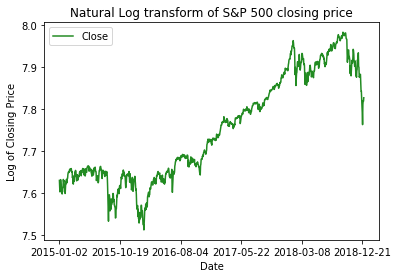

In [183]:
plt.figure(figsize=(9,5))
snp_close.plot(color="forestgreen")
plt.ylabel("Log of Closing Price")
plt.title("Natural Log transform of S&P 500 closing price")
plt.show()

To assess wether an ARMA or ARIMA model would be more appropriate for the S&P 500 time-series one must assess the stationarity of the dataset. As per 1.1.2 the stationarity of the dataset can be observed by computing the "sliding-window-based" first and second-order statistics (mean and variance) of the log-price time series.

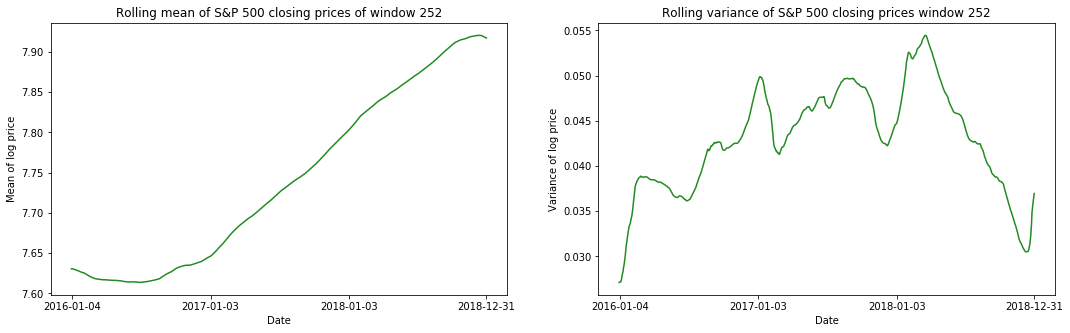

In [184]:
# sliding mean
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(snp_close.rolling(252).mean(), color="forestgreen")
#snp_close.rolling(252).mean().plot(color="forestgreen")
plt.xlabel("Date")
plt.xticks([252,504,756,1005])
plt.title("Rolling mean of S&P 500 closing prices of window 252")
plt.ylabel("Mean of log price")
# sliding standard deviation
plt.subplot(1,2,2)
plt.plot(snp_close.rolling(252).std(), color="forestgreen")
plt.xlabel("Date")
plt.xticks([252,504,756,1005])
plt.title("Rolling variance of S&P 500 closing prices window 252")
plt.ylabel("Variance of log price")
plt.show()

As observed above the S&P 500 closing price time series is not very stationary with both the rolling mean and variance varying through the time series. This suggests that an ARIMA model , which does not assume the data it is fitting to to be stationary is more appropriate for said time series.

#### 1.2.2 Fitting an ARMA(1,0) model

First an ARMA model with p=1 and m=0 (hence an AR(1) model) is fit on the data as follows:

In [185]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ["True"]
modelarma =  ARIMA(snp_arma , order = (1,0,0)).fit()
snp_arma["Res"] = modelarma.resid
arma_rmse = np.sqrt(np.mean(snp_arma["Res"]**2))
snp_arma["Prediction"] = snp_arma["True"] - snp_arma["Res"]

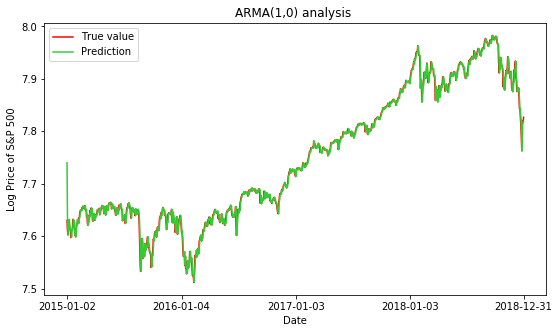

In [186]:
plt.figure(figsize=(9,5))
plt.plot(snp_arma["True"],color="red")
plt.plot(snp_arma["Prediction"],color="LimeGreen")
plt.xticks([0,252,504,756,1005])
plt.title("ARMA(1,0) analysis ")
plt.legend(["True value","Prediction"])
plt.xlabel("Date")
plt.ylabel("Log Price of S&P 500")
plt.show()

In [187]:
print("ARMA(1,0) RMSE: ",arma_rmse)

ARMA(1,0) RMSE:  0.009288255796724725


As you can see in the figure above, contrary to the fact that the data is not stationary the AR(1) model still fits the data well. This is because the AR(1) model is simply a random walk process in which the next value is predicted using only the previously value and random white noise. If one experiments with higher order models such as a AR(5) model and inspects the model parameters

In [190]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ["True"]
modelarma =  ARIMA(snp_arma , order = (5,0,0)).fit()
modelarma.params

const         7.737691
ar.L1.True    0.991302
ar.L2.True   -0.046989
ar.L3.True    0.064729
ar.L4.True   -0.078801
ar.L5.True    0.067357
dtype: float64

It is clear that the first coefficient (L1) which corresponds to the correlation to the previous snp closing price is almost 1 with all other coefficients much smaller and hence irrelevant. This confirms that the optimal order of the model is one where p=1 and provides further evidence that financial signals are martingales where the conditional expectation of the next value, given all prior values, is equal to the present value.

The problem with AR(1) models is that they are practically of very little use when attempting to forcast a time-series. The model simply takes the immediate past value and adds white noise to it. There is no useful information in the previous time values that can be used to forecast the future. If one assumed a completely efficient market scenario, an AR(1) would be optimal since any future values are just a random walk from the previous state however this is an assumption that is seldom made practically.

#### 1.2.3 Fitting an ARIMA(1,1,0) model

An ARIMA model of order such that p=1 d=1 and m=0 is then fit to the dataset as follows:

In [191]:
snp_arima = copy.deepcopy(snp_close)
snp_arima.columns = ["True"]
modelarima = ARIMA(snp_arma , order = (1,1,0)).fit()
snp_arima["Res"] = modelarima.resid
arima_rmse = np.sqrt(np.mean(snp_arima["Res"]**2))
snp_arima["Prediction"] = snp_arima["True"] - snp_arima["Res"]

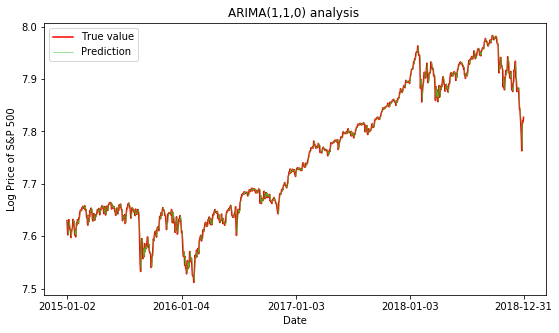

In [192]:
plt.figure(figsize=(9,5))
plt.plot(snp_arima["True"],color="red")
plt.plot(snp_arima["Prediction"],color="LimeGreen",linewidth=0.5)
plt.xticks([0,252,504,756,1005])
plt.title("ARIMA(1,1,0) analysis ")
plt.legend(["True value","Prediction"])
plt.xlabel("Date")
plt.ylabel("Log Price of S&P 500")
plt.show()

In [193]:
print("ARIMA(1,1,0) RMSE:",arima_rmse)

ARIMA(1,1,0) RMSE: 0.008618764909504159


As observed above the ARIMA(1,1,0) model also appears to predict the data well, however, if one once more experiments with a higher model order (p=20) it is found that the parameters are:

In [194]:
snp_arima = copy.deepcopy(snp_close)
snp_arima.columns = ["True"]
modelarima = ARIMA(snp_arima , order = (20,1,0)).fit()
snp_arima["Res"] = modelarima.resid
arima_rmse = np.sqrt(np.mean(snp_arima["Res"]**2))

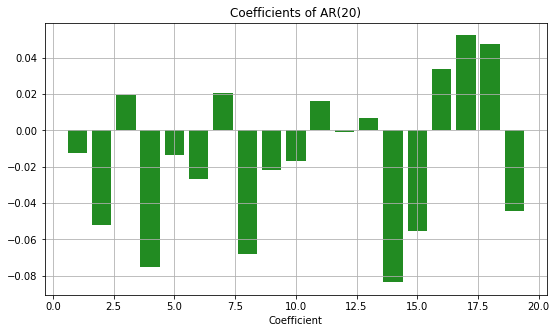

In [195]:
plt.figure(figsize=(9,5))
plt.bar(range(1,20,1),np.array([modelarima.params['ar.L' + str(i) +'.D.True'] for i in range(1,20)]),color="forestgreen")
plt.title('Coefficients of AR(20)')
plt.xlabel('Coefficient')
plt.grid()
plt.show()

In [196]:
print("ARIMA(20,1,0) RMSE:",arima_rmse)

ARIMA(20,1,0) RMSE: 0.008482892497369398


This analysis suggests that the optimal ARIMA model order is not infact one where p=1 as the L1 coefficient is much smaller in absolute value to 1 and a model order such that p=20 provides a RMSE of 0.0085 which although is not a large improvement is still significant $\geq 10^{-4}$. This suggests that the future difference in closing price has a correlation to more then just the previous difference. A more detailed investigation of this correlation by experimenting for an optimal ARIMA model order would then produce a much more feasible and physically meaningfull forcast and analysis of the market.

#### 1.2.4 Necessity of taking the log of the prices for the ARIMA analysis

By taking the log of the prices for the ARIMA analysis which inherently models the differences between prices one attempts to model the log returns of the prices. As mentioned in 1.1.4 as over short periods of time, prices tend to be distributed log-normally and hence the log returns r[t] will be normally distributed and hence stationary.

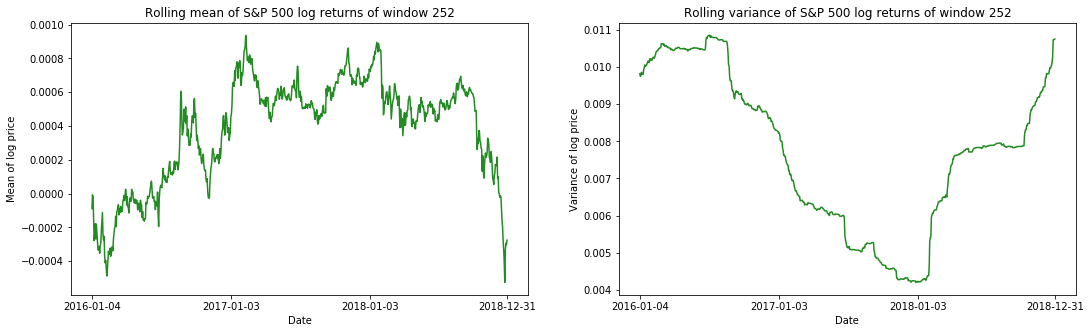

In [205]:
# log return 
logreturns = snp_close.diff()
# sliding mean
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(logreturns.rolling(252).mean(), color="forestgreen")
#snp_close.rolling(252).mean().plot(color="forestgreen")
plt.xlabel("Date")
plt.xticks([252,504,756,1005])
plt.title("Rolling mean of S&P 500 log returns of window 252")
plt.ylabel("Mean of log price")
# sliding standard deviation
plt.subplot(1,2,2)
plt.plot(logreturns.rolling(252).std(), color="forestgreen")
plt.xlabel("Date")
plt.xticks([252,504,756,1005])
plt.title("Rolling variance of S&P 500 log returns of window 252")
plt.ylabel("Variance of log price")
plt.show()

From the plots above for small windows of time the data can be assumed to be both first order and second order stationary. When compared to the plots in 1.2.1 it is evident that taking the log prices for arima analysis is paramount as it results in the AR modelling of data (log returns) that are much more stationary.

### 1.3 Vector Autoregressive (VAR) models:

A VAR(p) process is a multivariate extension of the AR processes given by:
$$\mathbf{y}_t = \mathbf{c} + \mathbf{A}_1\mathbf{y}_{t-1} + \mathbf{A}_2\mathbf{y}_{t-2}+ ... + \mathbf{A}_p\mathbf{y}_{t-p}+\mathbf{e}_t (1) $$

#### 1.3.1 Concise matrix form:

From Equation 1:
$$\mathbf{Y} = [\mathbf{c} ,\mathbf{A}_1,\mathbf{A}_2, ... ,\mathbf{A}_p ][1,\mathbf{y}_{t-1},\mathbf{y}_{t-2},...,\mathbf{y}_{t-p}]+ \mathbf{e}_t$$


The VAR model can be represented in a concise matrix form if one lets:

\begin{equation}
    \textbf{Y} = 
    \begin{pmatrix}
        y_{1,T-1} & y_{1,T-2} & \cdots & y_{1,0} \\
        y_{2,T-1} & y_{2,T-2} & \cdots & y_{2,0} \\
        \vdots        &       \vdots  & \ddots &       \vdots \\
        y_{K,T-1} & y_{K,T-2} & \cdots & y_{K,0} \\ 
    \end{pmatrix} \in R^{K \times T}
\end{equation}

<br>

\begin{equation}
    \textbf{B} = 
    \begin{pmatrix}
        c_{1}      &      a_{1,1}^{1} & a_{1,2}^{1} & \cdots & a_{1,K}^{1} & a_{1,1}^{2} \cdots & a_{1,K}^{P} \\
        c_{2}      &      a_{2,1}^{1} & a_{2,2}^{1} & \cdots & a_{2,K}^{1} & a_{2,1}^{2} \cdots & a_{2,K}^{P} \\
        \vdots      &      \vdots        &       \vdots  & \ddots &       \vdots  &  \vdots \quad  \ddots & \vdots \\
        c_{K}      &      a_{K,1}^{1} & a_{K,2}^{1} & \cdots & a_{K,K}^{1} & a_{K,1}^{2} \cdots & a_{K,K}^{P} \\ 
    \end{pmatrix} \in R^{K \times (KP + 1)}
\end{equation}

<br>

\begin{equation}
    \textbf{Z} = 
    \begin{pmatrix}
            1             &        1      & \cdots &     1     \\
        y_{1,t-1}^{1} & y_{1,t-2}^{1} & \cdots & y_{1,t-p}^{1} \\
        y_{2,t-1}^{1} & y_{2,t-2}^{1} & \cdots & y_{2,t-p}^{1} \\
        \vdots        &       \vdots  & \ddots &       \vdots \\
        y_{K,t-1}^{1} & y_{K,t-2}^{1} & \cdots & y_{K,t-p}^{1} \\
        y_{1,t-1}^{2} & y_{1,t-2}^{2} & \cdots & y_{1,t-p}^{2} \\
        \vdots        &       \vdots  & \ddots &       \vdots \\
        y_{K,t-1}^{p} & y_{K,t-2}^{p} & \cdots & y_{K,t-p}^{p} \\ 
    \end{pmatrix} \in R^{(KP + 1) \times T}
\end{equation}

<br>

\begin{equation}
    \textbf{U} = 
    \begin{pmatrix}
        e_{1,T-1} & e_{1,T-2} & \cdots & e_{1,0} \\
        e_{2,T-1} & e_{2,T-2} & \cdots & e_{2,0} \\
        \vdots    &   \vdots  & \ddots &   \vdots \\
        e_{K,T-1} & e_{K,T-2} & \cdots & e_{K,0} \\ 
    \end{pmatrix} \in R^{K \times T}
\end{equation}

Such that:
$$\mathbf{Y} = \mathbf{B}\mathbf{Z} + \mathbf{U}(2) $$

#### 1.3.2 Optimal set of coefficients

Given U is defined as the error term to find the optimal $\mathbf{B}_{opt}$ one must aim to minimise the square of said error term $\mathbf{U}^{T}\mathbf{U}$. To do so Equation 2 is reranged such that:

$$\mathbf{U}=\mathbf{Y}-\mathbf{B}\mathbf{Z}$$
$\mathbf{U}^{T}\mathbf{U}$ can now be found to be:
$$\mathbf{U}^{T}\mathbf{U}=(\mathbf{Y}-\mathbf{B}\mathbf{Z})^T(\mathbf{Y}-\mathbf{B}\mathbf{Z})$$


To minimise $\mathbf{U}^{T}\mathbf{U}$ it is differentiated with respect to B such that:
$$\frac{\partial \mathbf{U}^{T}\mathbf{U}}{\partial \mathbf{B}} = \frac{\partial \mathbf{U}^{T}\mathbf{U}}{\partial \mathbf{U}^{T}} \frac{\mathbf{U}^{T}}{\partial \mathbf{B}} $$
$$\frac{\partial \mathbf{U}^{T}\mathbf{U}}{\partial \mathbf{B}} =2(\mathbf{Y}-\mathbf{BZ})(-\mathbf{Z}^T)$$

$$\frac{\partial \mathbf{U}^{T}\mathbf{U}}{\partial \mathbf{B}} = -2 \mathbf{Y}\mathbf{Z}^T+2\mathbf{B}\mathbf{Z}\mathbf{Z}^T$$
And subsequently set to 0 such that:
$$0=-2 \mathbf{Y}\mathbf{Z}^T+2\mathbf{B}_{\text{opt}}\mathbf{Z}\mathbf{Z}^T$$
$$2\mathbf{B}_{\text{opt}}\mathbf{Z}\mathbf{Z}^T=2 \mathbf{Y}\mathbf{Z}^T$$
$$\mathbf{B}_{\text{opt}}\mathbf{Z}\mathbf{Z}^T=\mathbf{Y}\mathbf{Z}^T$$
$$\mathbf{B}_{\text{opt}}=\mathbf{Y}\mathbf{Z}^T(\mathbf{Z}\mathbf{Z}^T)^{-1}$$


#### 1.3.3 Stability Analysis

A VAR(1) process is given by the following equation

$$y_{t} = \textbf{A}y_{t-1} + e_{t}$$
For the system to be stable the eigenvalues of the matrix $\textbf{A}$ must be $<1$ in absolute value. This is proven by taking the Z-transform:
$$Y[z] = \textbf{A}Y[z]z^{-1} + E[z]$$
$$Y[z](\textbf{I}-\textbf{A}z^{-1}) = E[z]$$
$$\frac{Y[z]}{E[z]}=H[z]=\frac{1}{\textbf{I}-\textbf{A}z^{-1}}$$
A is then diagonalized such that:
$$\textbf{A} = \textbf{QDQ}^{-1} \Rightarrow H(z) = \frac{1}{\textbf{I} - \textbf{QDQ}^{-1}z^{-1}}$$

It is then evident that for the system to remain stable it is imparative that no column of $\textbf{D}$ (eigen value of $\textbf{A}=\lambda > 1$) 

To investigate how VAR models can aid in the construction of portfolio one must first need to import the following Python packages:

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR

In [199]:
df = pd.read_csv(r'snp_allstocks_2015_2019.csv')
df = df.set_index('Date')
info = pd.read_csv(r'snp_info.csv')
info.drop(columns=info.columns[0], inplace=True)

#### 1.3.4 VAR modelling selected stocks

In [207]:
tickers = ["CAG","MAR","LIN","HCP","MAT"]
stocks = df[tickers]
stocks_ma = stocks.rolling(window=66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

Fitting a VAR(1) model to the time-series and computing the eigen values of the regression matrix A

In [208]:
model = VAR(stocks_detrended)
results = model.fit(1)
A = results.params[1:].values
eigA, _ = np.linalg.eig(A)

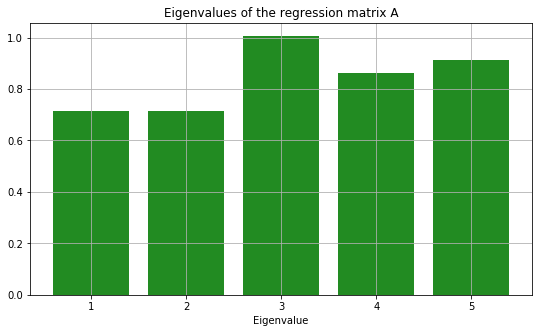

Selected Stock Model NOT Stable


In [209]:
plt.figure( figsize=(9,5))
plt.bar([1,2,3,4,5],eigA,color="ForestGreen")
plt.title('Eigenvalues of the regression matrix A')
plt.xlabel('Eigenvalue')
plt.grid()
plt.show()
#print(abs(eigA))
if max(abs(eigA))<1:
    print("Selected Stock Model Stable")
else:
    print("Selected Stock Model NOT Stable")

The eigenvalues of the regression matrix A are displayed above. It is clear that the third eigenvalue is greater than 1 and hence the model is unstable. Practically  when selecting a portfolio of stocks it is normaly of interest to find stocks that are very highly correlated (positively or negatively) or very independent. This is also not the case with said portofolio providing further reason as to why one should not construct a portfolio with said stocks.

In [63]:
plt.figure(figsize=(9,5))
plt.plot(["CAG","MAR","LIN","HCP","MAT"],np.transpose(A))
plt.legend(["CAG[t]","MAR[t]","LIN[t]","HCP[t]","MAT[t]"])
plt.xlabel("Stock closing price at [t-1]")
plt.ylabel("Correlation")
plt.grid

NameError: name 'A' is not defined

<Figure size 648x360 with 0 Axes>

#### 1.3.5 VAR modelling stocks by sector

In [203]:
for sector in info["GICS Sector"].unique():
    tickers = info.loc[info["GICS Sector"]==sector]["Symbol"].tolist()
    stocks=df[tickers]
    stocks_ma = stocks.rolling(window=66).mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()
    model = VAR(stocks_detrended)
    results = model.fit(1)
    A = results.params[1:].values
    eigA, _ = np.linalg.eig(A)
    if (max(abs(eigA)<1)):
        print(" {} Sector Model Stable".format(sector))
    else:
        print(" {} Sector Model NOT Stable".format(sector))

 Industrials Sector Model Stable
 Health Care Sector Model Stable
 Information Technology Sector Model Stable
 Communication Services Sector Model Stable
 Consumer Discretionary Sector Model Stable
 Utilities Sector Model Stable
 Financials Sector Model Stable
 Materials Sector Model Stable
 Real Estate Sector Model Stable
 Consumer Staples Sector Model Stable
 Energy Sector Model Stable


As observed above from a modelling point of view it is more stable to analyze stocks by sector rather than by individual value. Moreover, grouping the stocks by sector alows for information to obstained on how much a stock can be valued if a certain market level is reached and can also help when forcasting the performance of the company.

Investing in a sector rather than in individual diversified stocks conveys a greater risk. If an external event negatively effects an industry, all the stocks within that industry will plummet. Investing in a sector however minimizes the within-sector risk since all stocks follow a similar trend if they are correlated and furthermore the companies in the sector are often direct competitors and hence  If one company experiences growth it often causes another company to shrink.


## 2.Bond Pricing

In [26]:
import numpy as np

### 2.1 Examples of Bond pricing

1. An investor receives USD 1,100 in one year in return for an investment of USD 1,000 now

With an Investment $C_i=1000$
and a year_return $r_1=1100$:



a) Annual Compounding:
$$r_{1}=I \times (1+r_f)$$
$$r_f=\frac{r_{1}}{C_i}-1=0.1=10\%$$

b) Semiannual Compounding:

$$ r_1= C_i \times (1+\frac{rf}{2})^2 $$
$$ r_f=(\sqrt{\frac{r_1}{C_i}}-1) \times 2 = 0.0976=9.76\%$$

c) Monthly Compounding:

$$r_1=C_i \times (1+\frac{r_f}{12})^{12}$$
$$ r_f=[(\frac{r_1}{C_i})^{\frac{1}{12}}-1] \times 12 = 0.0956 = 9.56 \%  $$

d) Continous Compounding

$$r_1=C_i \times e^{r_f}$$
$$r_f = \log_{e}(\frac{r_1}{C_i})=0.0953=9.53\%$$

2.

The rate of interest with continous compounding that is equal to 15% per annum with monthly compounding can be found as follows:

$$C_i \times e^{\text{r}}=C_i \times (1+\frac{0.15}{12})^{12}$$
$$r=12\log_{e}(1+\frac{0.15}{12})=0.1491=14.91 \%$$

3. ASK QUESTION TO GTA

If a deposit account pays 12% per annum with continous compounding but interest is actually paid quarterly the interest paid for $10,000 deposit can be found to be:

$$\text{Return for Q1 (RQ1)}=\frac{C_i\times (e^{0.12}-1)}{4} = $318.74 $$

$$ \text{Return for Q2}=\frac{(C_i+\text{RQ1})\times e^{0.12}}{4} $$

$$ \text{Return for Q3 (RQ3)}=\frac{(C_i+\text{RQ1}+\text{RQ2})\times e^{0.12}}{4} $$

$$ \text{Return for Q4 (RQ4)}=\frac{(C_i+\text{RQ1}+\text{RQ2}+\text{RQ3})\times e^{0.12}}{4} $$

### Forward rates

If the one year interest rate $r_1 =5\%$ and the two year interest rate is $r_2 =7\%$. 

If one invests $C_i=\$100$ for one year the return is $100 \times 1.05 =\$105$

If one invests $C_i$ for two years the return is $100 \times 1.07^2= \$114.49$

The extra return that you earn for that second year is $\frac{1.07^2}{1.05}-1=0.090$ or $9.0 \%$

a) The Forward price of an asset can be found to be : $$F = S_0(r-q)T -\sum^{N}_{i=1}D_i(r-q)(T-t_i)$$

Where F is the forward price to be paid at time T, r is the risk free interest rate, q is the cost of carry $S_0$ is the spot price of the asset and $D_i$ is the dividend that is gauranteed at time t_i where $0<t_i<T$

For the example outlined above it can be concluded that there is no cost of carry, $q=0$ no divident $ D_i =0$ $\forall i $

b)

c)

d)

### Duration of a coupon-bearing bond

a)

In [3]:
Duration = sum([0.0124, 0.0236, 0.0337, 0.0428, 0.0510, 0.0583, 6.5377])
print("Duration = {}".format(Duration))

Duration = 6.7595


\begin{table}[]
\begin{tabular}{|l|lllllll|l|}
\hline
\textbf{Year}                                                                                          & \textbf{1} & \textbf{2} & \textbf{3} & \textbf{4} & \textbf{5} & \textbf{6} & \textbf{7} & \textbf{Total}                                                       \\ \hline
\textbf{Payment}                                                                                       & \$ 10      & \$ 10      & \$ 10      & \$ 10      & \$ 10      & \$  10     & \$ 1010    & \textbf{\$ 1070.00}                                                  \\ \hline
\textbf{PV($C_t$) at 5\%}                                                                              & \$ 9.52    & \$ 9.07    & \$ 8.64    & \$ 8.23    & \$ 7.84    & \$ 7.46    & \$ 717.79  & \textbf{PV = \$ 768.55}                                              \\ \hline
\textbf{\begin{tabular}[c]{@{}l@{}}Fraction of PV\\ {[} PV($C_t$)/PV {]}\end{tabular}}                 & 0.0124     & 0.0118     & 0.0112     & 0.0107     & 0.0102     & 0.0097     & 0.9340     &                                                                      \\ \hline
\textbf{\begin{tabular}[c]{@{}l@{}}Year × Fraction of PV \\ {[} t $\times$ PV(Ct)/PV {]}\end{tabular}} & 0.0124     & 0.0236     & 0.0337     & 0.0428     & 0.0510     & 0.0583     & 6.5377     & \textbf{\begin{tabular}[c]{@{}l@{}}Duration =\\ 6.7595\end{tabular}} \\ \hline
\end{tabular}
\end{table}

b)

In [4]:
y = 0.05
mod_duration = Duration/(1+y)
print("Modified Duration: {}".format(mod_duration))

Modified Duration: 6.437619047619047


$$ \text{Modified Duration} = \text{Volatility}(\%)=  \frac{\text{Duration}}{1+\text{yield}} = \frac{6.7595}{1+0.05} = 6.4376 $$

c) PLEASE COMPLETE

### Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)

In [196]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.read_csv(r"fsp_case_31_BSD.csv",index_col =0,header=[ 0 , 1])
df = df.fillna(0.0)

Market returns per day

In [197]:
ret_avg = df['ret'].mean(axis=1)
dates = df['ret'].index
d_axis = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

In [198]:
print("The average daily return across all days is: {}".format(np.mean(ret_avg)))

The average daily return across all days is: 6.094780982187611e-05


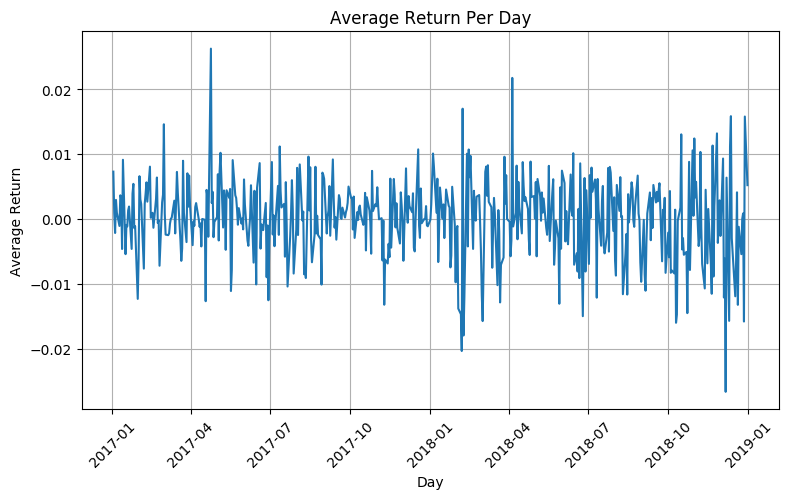

In [199]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(d_axis, ret_avg)
plt.title('Average Return Per Day')
plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Average Return')
plt.grid()
plt.show()

2. Rolling Beta

In [200]:
# print(ret_avg)
Covariances = df['ret'].rolling(22).cov(ret_avg).dropna()
Variances = ret_avg.rolling(22).var().dropna()
betas= pd.DataFrame(index=df.index)
for company in Covariances:
    betas.loc[21:,company] = Covariances[company]/Variances
betas=betas.fillna(0.0)

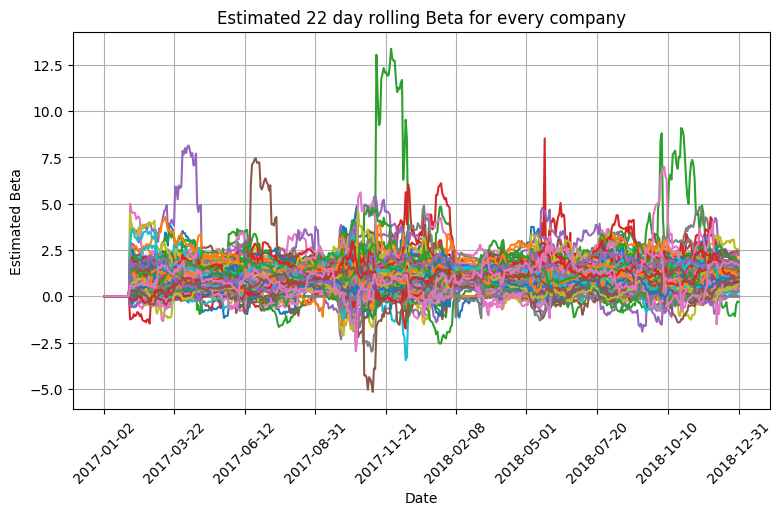

In [201]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(betas.index, betas)
plt.xticks([betas.index[i] for i in np.linspace(0,len(betas.index)-1, 10).astype(int)],rotation=45)
plt.title('Estimated 22 day rolling Beta for every company')
plt.xlabel('Date')
plt.ylabel('Estimated Beta')
plt.grid()
# plt.tight_layout()
plt.show()

3. Cap Weighted Market Return

In [202]:
mcap_tot = df['mcap'].sum(axis=1)
mcap_tot = np.array(mcap_tot)
numerator = df['ret']*df['mcap']
asset_returns = numerator/mcap_tot.reshape(-1,1)
market_returns = asset_returns.sum(axis=1)

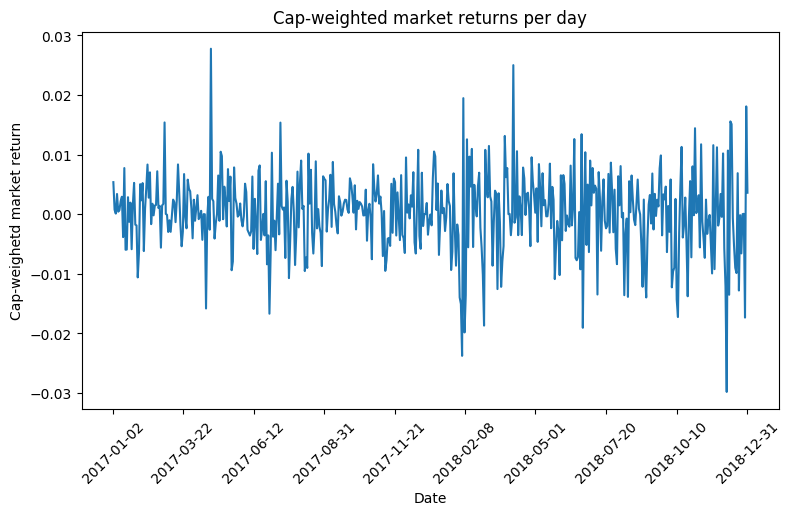

In [203]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(market_returns.index,market_returns)
plt.title("Cap-weighted market returns per day")
plt.xticks([market_returns.index[i] for i in np.linspace(0,len(market_returns.index)-1, 10).astype(int)],rotation=45)
plt.xlabel("Date")
plt.ylabel("Cap-weighetd market return")
plt.show()

4. Estimating Beta using cap-weighted market return

In [204]:
Covariances = df['ret'].rolling(22).cov(market_returns).dropna()
Variances = market_returns.rolling(22).var().dropna()
betas_m=pd.DataFrame(index=df.index)
for company in Covariances:
    betas_m.loc[21:,company] = Covariances[company]/Variances
betas_m = betas_m.fillna(0)

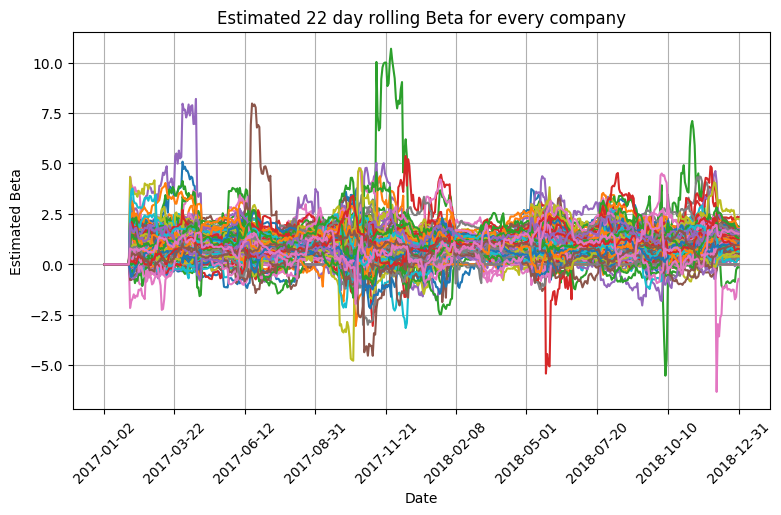

In [205]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(betas_m.index, betas_m)
plt.xticks([betas.index[i] for i in np.linspace(0,len(betas.index)-1, 10).astype(int)],rotation=45)
plt.title('Estimated 22 day rolling Beta for every company')
plt.xlabel('Date')
plt.ylabel('Estimated Beta')
plt.grid()
# plt.tight_layout()
plt.show()

5. Arbitrage Price Theory (**APT**)

a) Estimating $a$, $R_m$ and $R_s$

In [260]:
betas_s = np.log(df['mcap'])
betas_m = betas_m
betas_m.replace([np.inf, -np.inf], 0.0)
b_m=np.asarray(betas_m.fillna(0.0))
b_s=np.asarray(betas_s.fillna(0.0).replace([np.inf, -np.inf], 0.0))
Y=np.asarray(df['ret'])
epsilons=np.zeros((521,157))
predictions = pd.DataFrame(index=df.index)
i=21
for day in df.index[21:]:
#     print("bm: ",b_m[i])
#     print("bs: ",b_s[i])
    X=np.asarray([np.ones(157),b_m[i],b_s[i]])
#     print(X.T)
#     print("X shape:",X.shape)
#     print("y shape:",y.shape)
    y=np.asarray(Y[i])
    model=LinearRegression(fit_intercept=False)
    model.fit(X.T,y)
#     print(model.coef_)
    predictions.loc[day,'a']=model.coef_[0]
    predictions.loc[day,'Rm']=model.coef_[1]
    predictions.loc[day,'Rs']=model.coef_[2]
#     print(model.predict(X.T).shape)
#     print(y.shape)
    epsilons[i,:]=y-model.predict(X.T)
    i+=1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


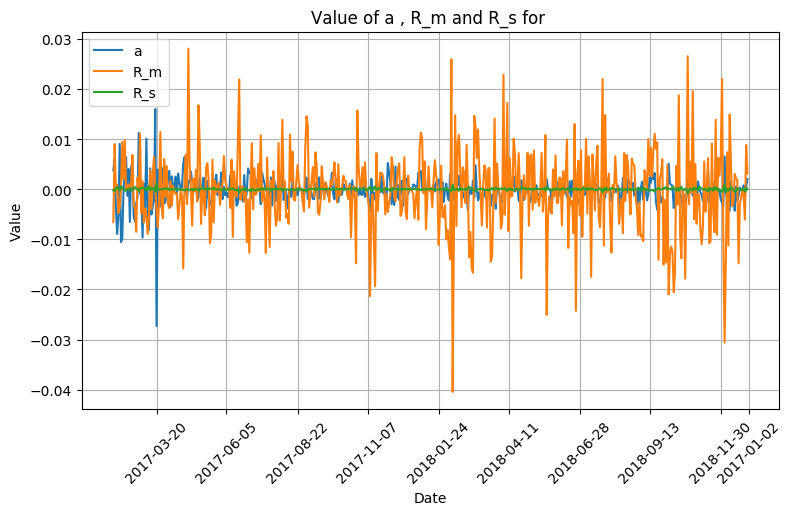

In [261]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(betas_m.index[21:], predictions['a'][21:],label="a")
plt.plot(betas_m.index[21:], predictions['Rm'][21:],label="R_m")
plt.plot(betas_m.index[21:], predictions['Rs'][21:],label='R_s')
plt.title('Value of a , R_m and R_s for ')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.xticks([betas.index[i] for i in np.linspace(0,len(betas.index[21:])-1, 10).astype(int)],rotation=45)
# plt.tight_layout()
plt.show()

b) Comment on $a$ , $R_m$ and $R_s$ 

In [262]:
a_mag = np.mean(predictions['a'][21:],axis=0)
a_var = np.var(predictions['a'][21:],axis=0)
print("Mean of a={} with variance={}".format(a_mag,a_var))
R_ms_mag = np.mean(predictions['Rm'][21:],axis=0)
R_ms_var = np.var(predictions['Rm'][21:],axis=0)
print("Mean of R_m={} with variance={}".format(R_ms_mag,R_ms_var))
R_ss_mag = np.mean(predictions['Rs'][21:],axis=0)
R_ss_var = np.var(predictions['Rs'][21:],axis=0)
print("Mean of R_s={} with variance={}".format(R_ss_mag,R_ss_var))

Mean of a=-0.00019002523109540564 with variance=7.72108389577303e-06
Mean of R_m=-0.0003230169616587331 with variance=6.11275862548631e-05
Mean of R_s=2.333977170982829e-05 with variance=4.352958049636715e-08


c) Correlations through time for every company

In [209]:
E = np.array(epsilons)
print(E.shape)
correlations=[]
i=0
for company in returns:
    correlations.append(np.dot(E[21:,i],returns[company][21:]))
    i+=1
correlations = np.asarray(correlations)
print(correlations.shape)

(521, 157)
(157,)


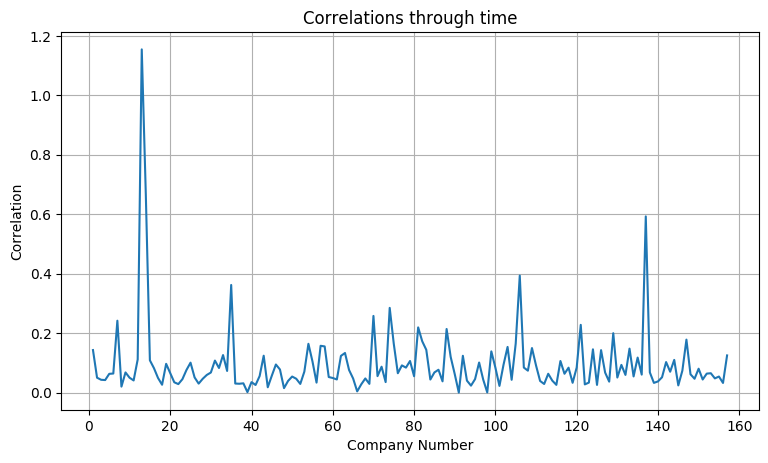

In [210]:
plt.figure(dpi=100, figsize=(9,5))
plt.plot(range(1,158), correlations)
plt.title('Correlations through time')
plt.xlabel('Company Number')
plt.ylabel('Correlation')
plt.grid()

# plt.tight_layout()
plt.show()

d)

In [257]:
print(predictions[21:].shape)
print(predictions["Rm"][21:].shape)
cov_r = predictions[21:].T.rolling(22).cov()
print(predictions[21:])
print(cov_R.shape)
print(cov_R)

cov_r2=np.cov(predictions[21:].T)
print(cov_r2)

(500, 2)
(500,)
                  Rm        Rs
2017-01-31 -0.006542 -0.000152
2017-02-01  0.009037 -0.000366
2017-02-02 -0.000610  0.000319
2017-02-03  0.000932  0.000448
2017-02-06 -0.004741  0.000094
...              ...       ...
2018-12-25  0.000000  0.000000
2018-12-26 -0.001302  0.000057
2018-12-27 -0.006036 -0.000437
2018-12-28  0.008858  0.000362
2018-12-31  0.003147  0.000016

[500 rows x 2 columns]
(2, 2)
[[nan nan]
 [nan nan]]
[[ 6.12500864e-05 -7.41052716e-07]
 [-7.41052716e-07  4.36168141e-08]]


e) Percentage of variance explained by the first principal component

In [227]:
print(E[21:].shape)
cov = np.cov(E[21:].T)
print(cov.shape)
eigenvalues, eigenvectors = np.linalg.eig(cov)
percentage = eigenvalues[0]/eigenvalues.sum() * 100
print("Percentage of variance explained by the first principal component: {}%".format(percentage))

(500, 157)
(157, 157)
Percentage of variance explained by the first principal component: 7.238427431929787%


## 3 Portfolio Optimization

### 3.1 Adaptive minimum-variance portfolio optimization

\begin{equation} 
\min_{\mathbf{w}} J(\mathbf{w},\mathbf{C})= \frac{1}{2}\mathbf{w}^T\mathbf{Cw} \label{min_var} \end{equation}

$$\text{Subject to: } \mathbf{w}^T\mathbf{1} = \mathbf{1}$$
Or equivalently, the Lagrange optimization:
$$\min_{\mathbf{w},\lambda} J'(\mathbf{w},\lambda , \mathbf{C})=\frac{1}{2}\mathbf{w}^T\mathbf{C}\mathbf{w}-\lambda(\mathbf{w^T1}-\mathbf{1})$$

If one differentiates with respect to $\lambda$:
$$\frac{\partial J'(\mathbf{w},\lambda ,\mathbf{C} )}{\partial \lambda} = -\mathbf{w}^T\mathbf{1}+\mathbf{1}$$
Setting $\frac{\partial J'(\mathbf{w},\lambda ,\mathbf{C} )}{\partial \lambda} =0$ yields:
$$\textbf{w}^T\mathbf{1}=1$$
As per the condition.

If one differentiates with respect to $\textbf{w}$:
$$ \frac{\partial J'(\mathbf{w},\lambda ,\mathbf{C} )}{\partial \mathbf{w}} = \mathbf{w}^T\mathbf{C}-\lambda \mathbf{1}$$
Setting $\frac{\partial J'(\mathbf{w},\lambda ,\mathbf{C} )}{\partial \mathbf{w}} =0$ yields:
$$\mathbf{w}^T\mathbf{C}=\lambda \mathbf{1}$$
Rearanging for $\mathbf{w}^T$:
$$ \mathbf{w}^T=\lambda \mathbf{1}\mathbf{C}^{-1}$$
If one multiplies by $\mathbf{1}$ on the right of both sides:
$$\mathbf{w}^T\mathbf{1}=\lambda \mathbf{1}\mathbf{C}^{-1}\mathbf{1}$$
Substituting the condition from above$\textbf{w}^T\mathbf{1}=1$ into this equation:
$$\mathbf{1} = \lambda \mathbf{1}\mathbf{C}^{-1}\mathbf{1}$$
Rearanging for $\lambda$ results in: 
$$\lambda = \mathbf{1}\mathbf{1}^T\mathbf{C}\mathbf{1}$$
Substituting this result back into